In [1]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
import math

import random

# to make the experimens replicable
random.seed(123456)


Using TensorFlow backend.


## Important

as first step run the notebook `1. classification-dataset-creation.ipynb` to create the dataset.

In [2]:
dataset_path = '../data/dataset-dirigenti-split.pkl'

with open(dataset_path, 'rb') as f:
    train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = pickle.load(f)

### Transform it in a dataset

In [3]:
train_samples[:5]

array([ list([148, 2192, 4, 37, 10, 4547, 7, 674, 5614, 7, 385, 4, 1941, 263, 8, 10407, 165, 358, 100, 1904, 4, 213, 14, 418, 816, 8, 5538, 1746, 6, 17429, 4, 12108, 3]),
       list([34, 29, 39, 212, 3, 249, 285, 1530, 2247, 9, 10, 1774, 253, 27, 811, 1489, 455, 13, 1591, 2713, 29160, 13983, 16, 9, 8, 35, 866, 90743, 3]),
       list([22, 3, 503, 28, 85, 30, 1140, 13, 590, 4, 1036, 948, 6927, 108, 3, 16, 4, 185, 3]),
       list([22, 3, 2758, 5, 6338, 882, 4003, 15, 78, 4616, 6, 104, 4543, 12]),
       list([163, 3, 65333, 5, 107, 14, 648, 34, 27, 90, 4, 6619, 36711, 38, 12214, 5, 17892, 20522, 17, 4421, 5, 36712, 52, 294, 19, 569, 393, 201, 17, 588, 7, 251, 2745, 3129, 3])], dtype=object)

In [4]:
train_labels[:5]

array([ 8, 16,  6, 20, 12])

In [5]:
samples = np.concatenate([train_samples,val_samples, test_samples])
samples.shape

(138043,)

In [6]:
labels = np.concatenate([train_labels, val_labels, test_labels])
labels.shape

(138043,)

## Tokenize the Dataset

In [7]:
from keras.preprocessing.text import Tokenizer

In [8]:
num_words = 10000

In [9]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(samples)

In [10]:
train_sequences = tokenizer.texts_to_sequences(train_samples)
val_sequences = tokenizer.texts_to_sequences(val_samples)
test_sequences = tokenizer.texts_to_sequences(test_samples)

In [11]:
for s in train_sequences[:2]:
    print(s)

[148, 2168, 2, 36, 8, 4375, 5, 668, 5370, 5, 380, 2, 1929, 259, 6, 9651, 164, 356, 100, 1944, 2, 210, 12, 433, 827, 6, 4984, 1770, 4, 2, 1]
[32, 27, 38, 212, 1, 244, 287, 1559, 2258, 7, 8, 1771, 256, 25, 790, 1524, 457, 11, 1525, 2719, 14, 7, 6, 33, 885, 1]


Convert labels to sequences

In [12]:
index_to_labels = dict(enumerate(set(labels)))
labels_to_index = {v:k for k,v in index_to_labels.items()}

In [13]:
labels[:10]

array([ 8, 16,  6, 20, 12,  7,  3, 11,  9,  1])

In [14]:
print(labels_to_index)
print(len(labels_to_index))

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19}
20


In [15]:
encoded_train_labels = [labels_to_index[l] for l in train_labels]
encoded_val_labels = [labels_to_index[l] for l in val_labels]
encoded_test_labels = [labels_to_index[l] for l in test_labels]

In [16]:
encoded_train_labels[:10]

[7, 15, 5, 19, 11, 6, 2, 10, 8, 0]

### Preparing Data

for data and labels

In [17]:
from keras.preprocessing import text

In [18]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [19]:
x_train = vectorize_sequences(train_sequences, num_words)
x_val = vectorize_sequences(val_sequences, num_words)
x_test = vectorize_sequences(test_sequences, num_words)

In [20]:
x_train[0:]

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [21]:
x_train.shape

(99390, 10000)

One hot encoding for the labels

In [22]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float16)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [23]:
y_train = to_one_hot(encoded_train_labels)
y_val = to_one_hot(encoded_val_labels)
y_test = to_one_hot(encoded_test_labels)

In [24]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float16)

## Build the Models

In [25]:
def build_model(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [26]:
model_small = build_model(16)
history_small = model_small.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)



Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 8s 85us/step - loss: 1.5843 - acc: 0.5298 - val_loss: 0.8614 - val_acc: 0.7232
Epoch 2/10
99390/99390 [==============================] - 7s 75us/step - loss: 0.6967 - acc: 0.7750 - val_loss: 0.6719 - val_acc: 0.7767
Epoch 3/10
99390/99390 [==============================] - 7s 75us/step - loss: 0.5343 - acc: 0.8230 - val_loss: 0.6178 - val_acc: 0.7914
Epoch 4/10
99390/99390 [==============================] - 8s 76us/step - loss: 0.4597 - acc: 0.8456 - val_loss: 0.5974 - val_acc: 0.8035
Epoch 5/10
99390/99390 [==============================] - 8s 76us/step - loss: 0.4116 - acc: 0.8608 - val_loss: 0.6017 - val_acc: 0.8035
Epoch 6/10
99390/99390 [==============================] - 8s 76us/step - loss: 0.3770 - acc: 0.8721 - val_loss: 0.6087 - val_acc: 0.8044
Epoch 7/10
99390/99390 [==============================] - 7s 75us/step - loss: 0.3496 - acc: 0.8806 - val_loss: 0.6190 - val_acc

In [27]:
model_medium = build_model(64)
history_medium = model_medium.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 8s 78us/step - loss: 1.0573 - acc: 0.6768 - val_loss: 0.5903 - val_acc: 0.8024
Epoch 2/10
99390/99390 [==============================] - 7s 69us/step - loss: 0.4563 - acc: 0.8427 - val_loss: 0.5309 - val_acc: 0.8162
Epoch 3/10
99390/99390 [==============================] - 7s 70us/step - loss: 0.3484 - acc: 0.8784 - val_loss: 0.5254 - val_acc: 0.8263
Epoch 4/10
99390/99390 [==============================] - 7s 69us/step - loss: 0.2860 - acc: 0.8994 - val_loss: 0.5416 - val_acc: 0.8281
Epoch 5/10
99390/99390 [==============================] - 7s 70us/step - loss: 0.2412 - acc: 0.9146 - val_loss: 0.5691 - val_acc: 0.8259
Epoch 6/10
99390/99390 [==============================] - 7s 70us/step - loss: 0.2066 - acc: 0.9273 - val_loss: 0.6105 - val_acc: 0.8257
Epoch 7/10
99390/99390 [==============================] - 7s 70us/step - loss: 0.1806 - acc: 0.9375 - val_loss: 0.6380 - val_acc

In [28]:
model_large = build_model(256)
history_large = model_large.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 9s 89us/step - loss: 0.8294 - acc: 0.7321 - val_loss: 0.5364 - val_acc: 0.8156
Epoch 2/10
99390/99390 [==============================] - 8s 85us/step - loss: 0.3646 - acc: 0.8707 - val_loss: 0.4812 - val_acc: 0.8331
Epoch 3/10
99390/99390 [==============================] - 8s 85us/step - loss: 0.2374 - acc: 0.9152 - val_loss: 0.5025 - val_acc: 0.8379
Epoch 4/10
99390/99390 [==============================] - 9s 90us/step - loss: 0.1571 - acc: 0.9450 - val_loss: 0.5562 - val_acc: 0.8379
Epoch 5/10
99390/99390 [==============================] - 8s 85us/step - loss: 0.1132 - acc: 0.9620 - val_loss: 0.5896 - val_acc: 0.8485
Epoch 6/10
99390/99390 [==============================] - 8s 85us/step - loss: 0.0877 - acc: 0.9707 - val_loss: 0.6344 - val_acc: 0.8427
Epoch 7/10
99390/99390 [==============================] - 8s 85us/step - loss: 0.0704 - acc: 0.9769 - val_loss: 0.6860 - val_acc

### Printing The Loss

In [29]:
import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
def chart_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.yticks(np.arange(0,2.25,0.25))
    plt.legend()
    plt.show()

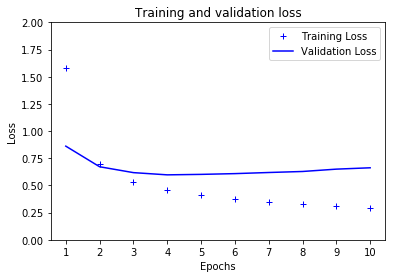

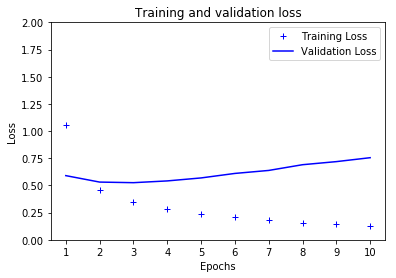

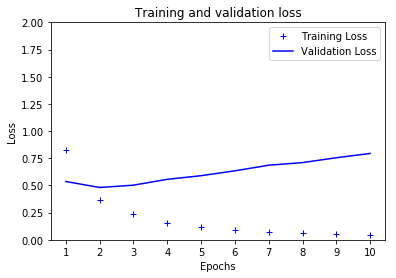

In [31]:
chart_loss(history_small)
chart_loss(history_medium)
chart_loss(history_large)

In [32]:
def chart_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.xticks(epochs)
    plt.yticks(np.arange(0,1.1,0.1))
    plt.legend()
    plt.show()

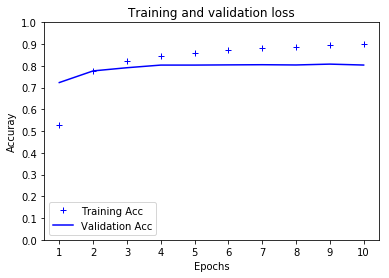

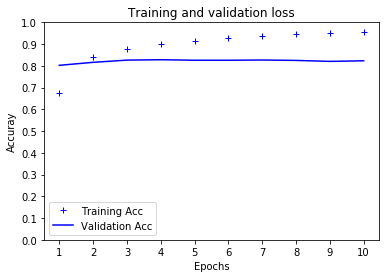

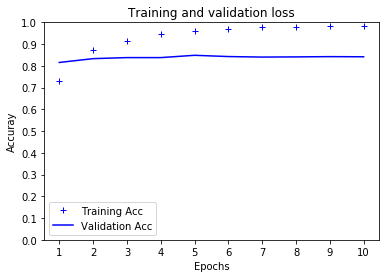

In [33]:
chart_acc(history_small)
chart_acc(history_medium)
chart_acc(history_large)

In [34]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

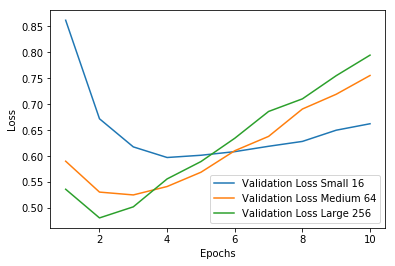

In [35]:
compare_loss({'Small 16': history_small, 'Medium 64': history_medium, 'Large 256': history_large})

In [36]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

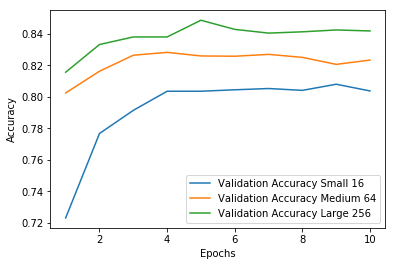

In [37]:
compare_accuracy({'Small 16': history_small, 'Medium 64': history_medium, 'Large 256': history_large})

In [38]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss) + 1   

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch-1]

In [39]:
print('min loss for model small is {}'.format(min_loss(history_small)))
print('min loss for model medium is {}'.format(min_loss(history_medium)))
print('min loss for model large is {}'.format(min_loss(history_large)))

min loss for model small is 4
min loss for model medium is 3
min loss for model large is 2


In [40]:
print('best validation accuracy for model small is {}'.format(
    accuracy(history_small, min_loss(history_small))))
print('best validation accuracy for model medium is {}'.format(
    accuracy(history_medium, min_loss(history_medium))))
print('best validation accuracy for model large is {}'.format(
    accuracy(history_medium, min_loss(history_medium))))

best validation accuracy for model small is 0.8035132198262931
best validation accuracy for model medium is 0.8263310395432141
best validation accuracy for model large is 0.8263310395432141


### Evaluate on the Test Set

- train the best model for the best epochs

In [41]:
import gc

In [45]:
gc.collect()

0

In [46]:
model = build_model(256)

In [47]:
history = model.fit(x=np.concatenate([x_train, x_val]), y=np.concatenate([y_train, y_val]), epochs=2, batch_size=256)

Epoch 1/2
110434/110434 [==============================] - 10s 89us/step - loss: 0.7895 - acc: 0.7432
Epoch 2/2
110434/110434 [==============================] - 8s 73us/step - loss: 0.3574 - acc: 0.8728


In [48]:
loss, acc = model.evaluate(x_test, y_test)

27609/27609 [==============================] - 3s 106us/step


In [49]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 0.47464623744279905
acc 0.8366112499309771
